Calibrated weights (R, G, B): [0.50300348 0.42320582 0.07379071]


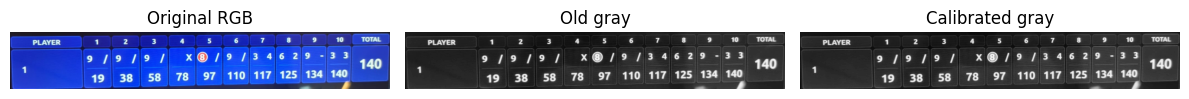

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1) Calibrate grayscale weights by class means
bg_samples = np.array([
    [27, 61, 221],
    [30, 63, 220],
    [4, 114, 212],
    [3, 122, 248],
    [39, 73, 224],
    [0, 98, 222]
], dtype=float)

fg_samples = np.array([
    [240, 251, 245],
    [213, 255, 251],
    [225, 255, 253],
    [209, 243, 255],
    [223, 255, 255],
    [150, 231, 252],
    [186, 245, 255]
], dtype=float)

mu_bg = bg_samples.mean(axis=0)
mu_fg = fg_samples.mean(axis=0)
w = mu_fg - mu_bg # difference vector => direction maximizing separation
w_norm = w / w.sum() # normalize to sum = 1
print("Calibrated weights (R, G, B):", w_norm)

# 2) Compare old vs. new grayscale on one image
img = cv2.imread('data/images/20250612-game2.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# old method
b, g, r = cv2.split(img)
old_gray = cv2.addWeighted(r, 0.5, g, 0.5, 0)

# new method
new_gray = (w_norm[0]*r + w_norm[1]*g + w_norm[2]*b).astype(np.uint8)

# display side-by-side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img_rgb); axes[0].set_title("Original RGB"); axes[0].axis('off')
axes[1].imshow(old_gray, cmap='gray'); axes[1].set_title("Old gray"); axes[1].axis('off')
axes[2].imshow(new_gray, cmap='gray'); axes[2].set_title("Calibrated gray"); axes[2].axis('off')
plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# ---------------------- Calibration & Parameters ----------------------
# Calibrated grayscale weights (R, G, B)
W = np.array([0.50300348, 0.42320582, 0.07379071])

# HSV thresholds for the blue scoreboard (approx. hue ~110°)
lower_blue = np.array([100,  50,  50])
upper_blue = np.array([130, 255, 255])

# OCR config: single-line mode, whitelist digits, X, /, -, F
config = '--psm 7 -c tessedit_char_whitelist=123456789X/-F'


# ---------------------- Helper Functions ----------------------
def to_gray(img):
    """Convert BGR image to grayscale using calibrated weights."""
    b, g, r = cv2.split(img)
    gray = (W[0]*r + W[1]*g + W[2]*b).astype(np.uint8)
    return gray

def remove_red_circles(bgr):
    """Inpaint red circular overlays back to the board color."""
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv, np.array([0, 100, 100]), np.array([10, 255, 255]))
    mask2 = cv2.inRange(hsv, np.array([170, 100, 100]), np.array([180, 255, 255]))
    red_mask = cv2.bitwise_or(mask1, mask2)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    return cv2.inpaint(bgr, red_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

def detect_skew_by_hough(gray):
    """Detect small skew by Hough line transform on vertical grid lines."""
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
    if lines is None:
        return 0.0
    angles = []
    for rho, theta in lines[:,0]:
        deg = theta * 180/np.pi - 90
        if abs(deg) < 10:  # near-vertical lines
            angles.append(deg)
    if not angles:
        return 0.0
    angle = float(np.median(angles))
    # clamp to [-5°, +5°]
    return float(np.clip(angle, -5.0, 5.0))

def rotate(img, angle):
    """Rotate image around center by -angle degrees (to deskew)."""
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), -angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)

def crop_row(img):
    """Crop the central band containing the bowler's score row."""
    h = img.shape[0]
    return img[int(0.3*h):int(0.59*h), :]

def split_frames(img):
    """Split the row into 10 equal-width slices (prototype)."""
    h, w = img.shape[:2]
    frames = []
    for i in range(10):
        x1 = int(i * w / 10)
        x2 = int((i + 1) * w / 10)
        frames.append(img[:, x1:x2])
    return frames

def preprocess_for_ocr(gray):
    """Binarize the grayscale image to maximize character contrast."""
    # 1) Global Otsu
    _, bin_glob = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 2) Adaptive threshold
    bin_adapt = cv2.adaptiveThreshold(gray, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV,
                                      blockSize=15, C=2)
    # 3) Closing to fill small holes
    kernel = np.ones((3,3), np.uint8)
    bin_closed = cv2.morphologyEx(bin_adapt, cv2.MORPH_CLOSE, kernel, iterations=1)
    # Choose the mask with more ink (simple heuristic)
    return bin_glob if bin_glob.sum() > bin_closed.sum() else bin_closed


# ---------------------- Testing on Sample Images ----------------------
tests = [
    ('data/images/20250612-game10.jpeg',
     ['45','9/','81','X','9/','X','9/','8/','1/','9/4']),
    ('data/images/20250421-game6.jpg',
     ['81','51','9-','9-','4/','7-','9-','34','15','9F']),
    ('data/images/20250612-game7.jpg',
     ['6/','71','X','X','8/','X','9-','9/','8-','81'])
]

for path, gt in tests:
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    
    # 1) Crop & skew-detect on the row
    row = crop_row(img)
    gray_row = to_gray(remove_red_circles(row))
    angle = detect_skew_by_hough(gray_row)
    
    # 2) Deskew full image and re-crop
    img_deskew = rotate(img, angle)
    row = crop_row(img_deskew)
    
    # 3) Frame-split, clean, binarize, and OCR
    ocr_res = []
    for fr in split_frames(row):
        fr_clean = remove_red_circles(fr)
        g = to_gray(fr_clean)
        mask = preprocess_for_ocr(g)
        text = pytesseract.image_to_string(mask, config=config).strip().replace(' ', '')
        ocr_res.append(text)
    
    print(f"\n{path}")
    print(" Detected skew:     {:.2f}°".format(angle))
    print(" OCR result:        ", ocr_res)
    print(" Ground truth:      ", gt)
    print(" Exact match:       ", ocr_res == gt)


data/images/20250612-game10.jpeg
 Detected skew:     0.00°
 OCR result:         ['45', '9/', '81', 'X', '9/', 'X', '9/', '8/', '', '9/4']
 Ground truth:       ['45', '9/', '81', 'X', '9/', 'X', '9/', '8/', '1/', '9/4']
 Exact match:        False

data/images/20250421-game6.jpg
 Detected skew:     0.00°
 OCR result:         ['1', '51', '9-', '9-', '4/', '7-', '9-', '34', '15', '']
 Ground truth:       ['81', '51', '9-', '9-', '4/', '7-', '9-', '34', '15', '9F']
 Exact match:        False

data/images/20250612-game7.jpg
 Detected skew:     -1.00°
 OCR result:         ['6/', '71', 'X', 'X', '8/', 'X', '9-', '9/', '', '81']
 Ground truth:       ['6/', '71', 'X', 'X', '8/', 'X', '9-', '9/', '8-', '81']
 Exact match:        False
